#  setup environment

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import zipfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import PIL
from PIL import Image

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

# extracting bangla dataset 

In [8]:
num_classes=84
np.random.seed(133)
data_root='.'
full_filename=os.path.join(data_root, 'BanglaLekha-Isolated.zip')


def maybe_extract(filename, force=False):
    root=os.path.splitext(os.path.splitext(filename)[0])[0]
    root=root #as the classesdata are in images folder
    if os.path.isdir(root)and not force:
        print('%s already present - Skipping extraction of %s' %(root, filename))
    else:
        print('extracting data %s.this may take a while .please wait.' %root)
        zip=zipfile.ZipFile(filename)
        sys.stdout.flush()
        zip.extractall(data_root)
        zip.close()
    data_folders = [
        os.path.join(root, d)for d in sorted(os.listdir(root)) #listing all the classes directory
        if os.path.isdir(os.path.join(root, d))]
    if len(data_folders) !=num_classes: #checks lengths
        raise Exception(
            'Expected %d folders , one per class. found %d instead.' % (
                num_classes,len(data_folders)))
    print(data_folders)
    return data_folders

full_folders=maybe_extract(full_filename)
        

./BanglaLekha-Isolated already present - Skipping extraction of ./BanglaLekha-Isolated.zip
['./BanglaLekha-Isolated/1', './BanglaLekha-Isolated/10', './BanglaLekha-Isolated/11', './BanglaLekha-Isolated/12', './BanglaLekha-Isolated/13', './BanglaLekha-Isolated/14', './BanglaLekha-Isolated/15', './BanglaLekha-Isolated/16', './BanglaLekha-Isolated/17', './BanglaLekha-Isolated/18', './BanglaLekha-Isolated/19', './BanglaLekha-Isolated/2', './BanglaLekha-Isolated/20', './BanglaLekha-Isolated/21', './BanglaLekha-Isolated/22', './BanglaLekha-Isolated/23', './BanglaLekha-Isolated/24', './BanglaLekha-Isolated/25', './BanglaLekha-Isolated/26', './BanglaLekha-Isolated/27', './BanglaLekha-Isolated/28', './BanglaLekha-Isolated/29', './BanglaLekha-Isolated/3', './BanglaLekha-Isolated/30', './BanglaLekha-Isolated/31', './BanglaLekha-Isolated/32', './BanglaLekha-Isolated/33', './BanglaLekha-Isolated/34', './BanglaLekha-Isolated/35', './BanglaLekha-Isolated/36', './BanglaLekha-Isolated/37', './BanglaLek

# Image padding

# Convert images into npArray and save into pickle file with separate class


In [13]:
image_size=28 #pixel width and height
pixel_depth=255.0 #Nurmber of levels per pixel

def load_letter(folder, min_num_images):
    """Load the data for a single letter label"""
    image_files=os.listdir(folder)
    dataset=np.ndarray(shape=(len(image_files),image_size, image_size),dtype=np.float32)
    print(folder)
    num_images=0
    for image in image_files:
        image_file=os.path.join(folder,image)
        try:
            image_data=(ndimage.imread(image_file).astype(float) - pixel_depth /2)/pixel_depth
            if image_data.shape !=(image_size,image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape),(image_file))
            dataset[num_images,:,:]=image_data
            num_images=num_images + 1
        except IOError as e:
            print('couldnot read :', image_file , ':', e , '-it\'s ok , skipping.')
    dataset=dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('many fewer images then expected: %d < %d' % (num_images, min_num_images))
    print('Full dataset tensor:', dataset.shape)
    print('mean:', np.mean(dataset))
    print('standard deviation:', np.std(dataset))
    return dataset

def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names=[]
    for folder in data_folders:
        set_filename=folder+ '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename)and not force:
            print('%s already present - skipping pickling.' % set_filename)
        else:
            print('pickling %s.' % set_filename)
            dataset=load_letter(folder,min_num_images_per_class)
            try:
                with open(set_filename, 'wb')as f:
                    pickle.dump(dataset,f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':',e)
    return dataset_names
full_datasets=maybe_pickle(full_folders, 1900)#Not MNIST Large

#print (full_datasets.shape)








./BanglaLekha-Isolated/1.pickle already present - skipping pickling.
./BanglaLekha-Isolated/10.pickle already present - skipping pickling.
./BanglaLekha-Isolated/11.pickle already present - skipping pickling.
./BanglaLekha-Isolated/12.pickle already present - skipping pickling.
./BanglaLekha-Isolated/13.pickle already present - skipping pickling.
./BanglaLekha-Isolated/14.pickle already present - skipping pickling.
./BanglaLekha-Isolated/15.pickle already present - skipping pickling.
./BanglaLekha-Isolated/16.pickle already present - skipping pickling.
./BanglaLekha-Isolated/17.pickle already present - skipping pickling.
./BanglaLekha-Isolated/18.pickle already present - skipping pickling.
./BanglaLekha-Isolated/19.pickle already present - skipping pickling.
./BanglaLekha-Isolated/2.pickle already present - skipping pickling.
./BanglaLekha-Isolated/20.pickle already present - skipping pickling.
./BanglaLekha-Isolated/21.pickle already present - skipping pickling.
./BanglaLekha-Isolated

 # shuffle images from each class to have random validation and training set then merge each classes into a single dataset

In [15]:
#print (train_dataset.shape)
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset=np.ndarray((nb_rows, img_size , img_size), dtype=np.float32)
        labels=np.ndarray(nb_rows,dtype=np.float32)
    else:
        dataset,labels=None, None
    return dataset,labels
def merge_datasets(pickle_files,train_size, valid_size=0):
    num_classes= len(pickle_files)
    valid_dataset, valid_labels= make_arrays(valid_size, image_size)#for validation 
    train_dataset, train_labels= make_arrays(train_size, image_size)
    vsize_per_class= valid_size // num_classes
    tsize_per_class= train_size // num_classes
    
    start_v,start_t =0 , 0
    end_v, end_t =vsize_per_class , tsize_per_class
    end_l=vsize_per_class+tsize_per_class
    for label, pickle_file in enumerate(pickle_files):#label=value or index of pickle files,example A,B,C,D
        try:
            with open(pickle_file, 'rb') as f:
                letter_set=pickle.load(f)
                #shuffle the letters to have random validation and training set
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    valid_letter=letter_set[:vsize_per_class, : , :]
                    valid_dataset[start_v:end_v, : , :] = valid_letter
                    valid_labels[start_v:end_v]= label
                    start_v +=vsize_per_class
                    end_v += vsize_per_class
                    
                train_letter= letter_set[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t, : ,:]=train_letter
                train_labels[start_t:end_t]=label
                start_t +=tsize_per_class
                end_t += tsize_per_class
        except Exception as e:
            print('unable to process data from', pickle_file, '.', e)
            raise
    return valid_dataset,valid_labels,train_dataset, train_labels

train_size= 139000
valid_size=10000
test_size=10000

valid_dataset, valid_labels,train_dataset,train_labels = merge_datasets(full_datasets, train_size , valid_size)
test_dataset, test_labels,train_dataset,train_labels=merge_datasets(full_datasets,train_size,test_size)

print('training: ' ,train_dataset.shape , train_labels.shape)
print('validation :' , valid_dataset.shape , valid_labels.shape)
print('test :', test_dataset.shape , test_labels.shape)
                    

training:  (139000, 28, 28) (139000,)
validation : (10000, 28, 28) (10000,)
test : (10000, 28, 28) (10000,)


In [29]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    print (labels.shape[0])
    print (permutation)
    shuffled_dataset= dataset[permutation, : , :]
    shuffled_labels= labels[permutation]
    return shuffled_dataset, shuffled_labels
train_dataset , train_labels = randomize(train_dataset, train_labels)
test_dataset , test_labels = randomize(test_dataset, test_labels)
valid_dataset , valid_labels = randomize(valid_dataset, valid_labels)

    
    

139000
[54740 25921 54452 ..., 70445 63056  7162]
10000
[5448 6261  849 ..., 8146 6939 4309]
10000
[4254 4474 9466 ..., 1087 4600 1649]


10.0


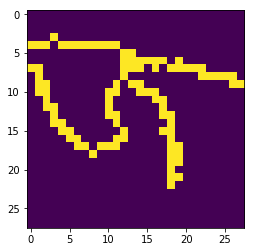

In [30]:
imgplot = plt.imshow(train_dataset [0])
print (train_labels[0])


In [31]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')
try:
    f = open(pickle_file , 'wb')
    save= {
        'train_dataset' : train_dataset,
        'train_labels'  : train_labels,
        'valid_dataset' : valid_dataset,
        'valid_labels'  : valid_labels,
        'test_dataset'  : test_dataset,
        'test_labels'    : test_labels,
    }
    pickle.dump(save, f , pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('unable to save data to', pickle_file , ':', e)
    raise

In [32]:
statinfo= os.stat(pickle_file)
print('compressed pickcle size:', statinfo.st_size)

compressed pickcle size: 499260406


In [33]:
import time
import hashlib

f=open(pickle_file, 'rb')
read_pickle = pickle.load( f )
train_dataset=read_pickle['train_dataset']
print(train_dataset)
train_labels=read_pickle['train_labels']
valid_dataset=read_pickle['valid_dataset']
valid_labels=read_pickle['valid_labels']
test_dataset=read_pickle['test_dataset']
test_labels=read_pickle['test_labels']



t1 = time.time()

train_hashes = [hashlib.sha1(x).digest() for x in train_dataset]
valid_hashes = [hashlib.sha1(x).digest() for x in valid_dataset]
test_hashes  = [hashlib.sha1(x).digest() for x in test_dataset]

valid_in_train = np.in1d(valid_hashes, train_hashes)
test_in_train  = np.in1d(test_hashes,  train_hashes)
test_in_valid  = np.in1d(test_hashes,  valid_hashes)

valid_keep = ~valid_in_train
test_keep  = ~(test_in_train | test_in_valid)

valid_dataset_clean = valid_dataset[valid_keep]
valid_labels_clean  = valid_labels [valid_keep]

test_dataset_clean = test_dataset[test_keep]
test_labels_clean  = test_labels [test_keep]

t2 = time.time()

print("Time: %0.2fs" % (t2 - t1))
print("valid -> train overlap: %d samples" % valid_in_train.sum())
print("test  -> train overlap: %d samples" % test_in_train.sum())
print("test  -> valid overlap: %d samples" % test_in_valid.sum())

[[[-0.5 -0.5 -0.5 ..., -0.5 -0.5 -0.5]
  [-0.5 -0.5 -0.5 ..., -0.5 -0.5 -0.5]
  [-0.5 -0.5 -0.5 ..., -0.5 -0.5 -0.5]
  ..., 
  [-0.5 -0.5 -0.5 ..., -0.5 -0.5 -0.5]
  [-0.5 -0.5 -0.5 ..., -0.5 -0.5 -0.5]
  [-0.5 -0.5 -0.5 ..., -0.5 -0.5 -0.5]]

 [[-0.5 -0.5 -0.5 ..., -0.5 -0.5 -0.5]
  [-0.5 -0.5 -0.5 ..., -0.5 -0.5 -0.5]
  [-0.5 -0.5 -0.5 ..., -0.5 -0.5 -0.5]
  ..., 
  [-0.5 -0.5 -0.5 ..., -0.5 -0.5 -0.5]
  [-0.5 -0.5 -0.5 ..., -0.5 -0.5 -0.5]
  [-0.5 -0.5 -0.5 ..., -0.5 -0.5 -0.5]]

 [[-0.5 -0.5 -0.5 ..., -0.5 -0.5 -0.5]
  [-0.5 -0.5  0.5 ..., -0.5 -0.5 -0.5]
  [-0.5 -0.5  0.5 ..., -0.5 -0.5 -0.5]
  ..., 
  [-0.5 -0.5  0.5 ..., -0.5 -0.5 -0.5]
  [-0.5 -0.5  0.5 ..., -0.5 -0.5 -0.5]
  [-0.5 -0.5  0.5 ..., -0.5 -0.5 -0.5]]

 ..., 
 [[-0.5 -0.5 -0.5 ..., -0.5 -0.5 -0.5]
  [-0.5 -0.5 -0.5 ...,  0.5 -0.5 -0.5]
  [-0.5 -0.5 -0.5 ...,  0.5  0.5 -0.5]
  ..., 
  [-0.5 -0.5 -0.5 ..., -0.5 -0.5 -0.5]
  [-0.5 -0.5 -0.5 ..., -0.5 -0.5 -0.5]
  [-0.5 -0.5 -0.5 ..., -0.5 -0.5 -0.5]]

 [[-0.5 -0.5 -0.5

In [34]:
print (test_dataset_clean.shape)
print (test_dataset_clean.size)
print (valid_dataset_clean.shape)
print (valid_dataset_clean.size)
print (train_dataset.shape)
print (train_dataset.size)

(9307, 28, 28)
7296688
(1698, 28, 28)
1331232
(139000, 28, 28)
108976000
